### 데이터 정규화

#### 데이터 정규화 처리하기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense
# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 회귀분석을 수행하는 통계 패키지 (머신러닝과는 연관 없음)
from statsmodels.formula.api import ols

# 데이터 정규화를 위한 패키지 참조
from sklearn.preprocessing import MinMaxScaler

#### 데이터 준비

In [2]:
df = pd.read_excel('http://itpaper.co.kr/data/cars.xlsx', engine='openpyxl')
df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


#### 데이터셋 분할

In [3]:
# 랜덤시드 고정

np.random.seed(777)

In [4]:
# 훈련 데이터(독립변수)와 레이블(종속변수) 구분

x_train_set = df.filter(['speed'])
y_train_set = df.filter(['dist'])
print("훈련데이터 크기:", x_train_set.shape, "/ 레이블 크기:", y_train_set.shape)

훈련데이터 크기: (50, 1) / 레이블 크기: (50, 1)


In [5]:
# 훈련데이터와 검증 데이터로 분할

# 독립변수인 `speed`를 훈련용 독립변수 `x_train`과 검정용 독립변수 `x_test`로 나눈다.
# 종속변수인 `dist`를 훈련용 종속변수 `y_train`과 검정용 종속변수 `y_test`로 나눈다.
# 훈련용 데이터셋과 검정용 데이터셋은 일반적으로 7:3의 비율로 한다.

x_train, x_test, y_train, y_test = train_test_split(x_train_set, y_train_set, 
                                        test_size = 0.33, random_state = 777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 33, 검증용 데이터셋 크기: 17


In [6]:
# 모델 정의

model = Sequential()
# 1차원의 데이터를 입력으로 받고, 32개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(32, activation = 'relu', input_shape = (1, )))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함.
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


#### 맨위부터 여기까지는 단순 선형 회귀 에서다룬내용과 같은 사항

In [7]:
# 데이터 정규화

scaler = MinMaxScaler()
std_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
std_x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
std_y_train = pd.DataFrame(scaler.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
std_y_test = pd.DataFrame(scaler.transform(y_test), columns=y_test.columns, index=y_test.index)

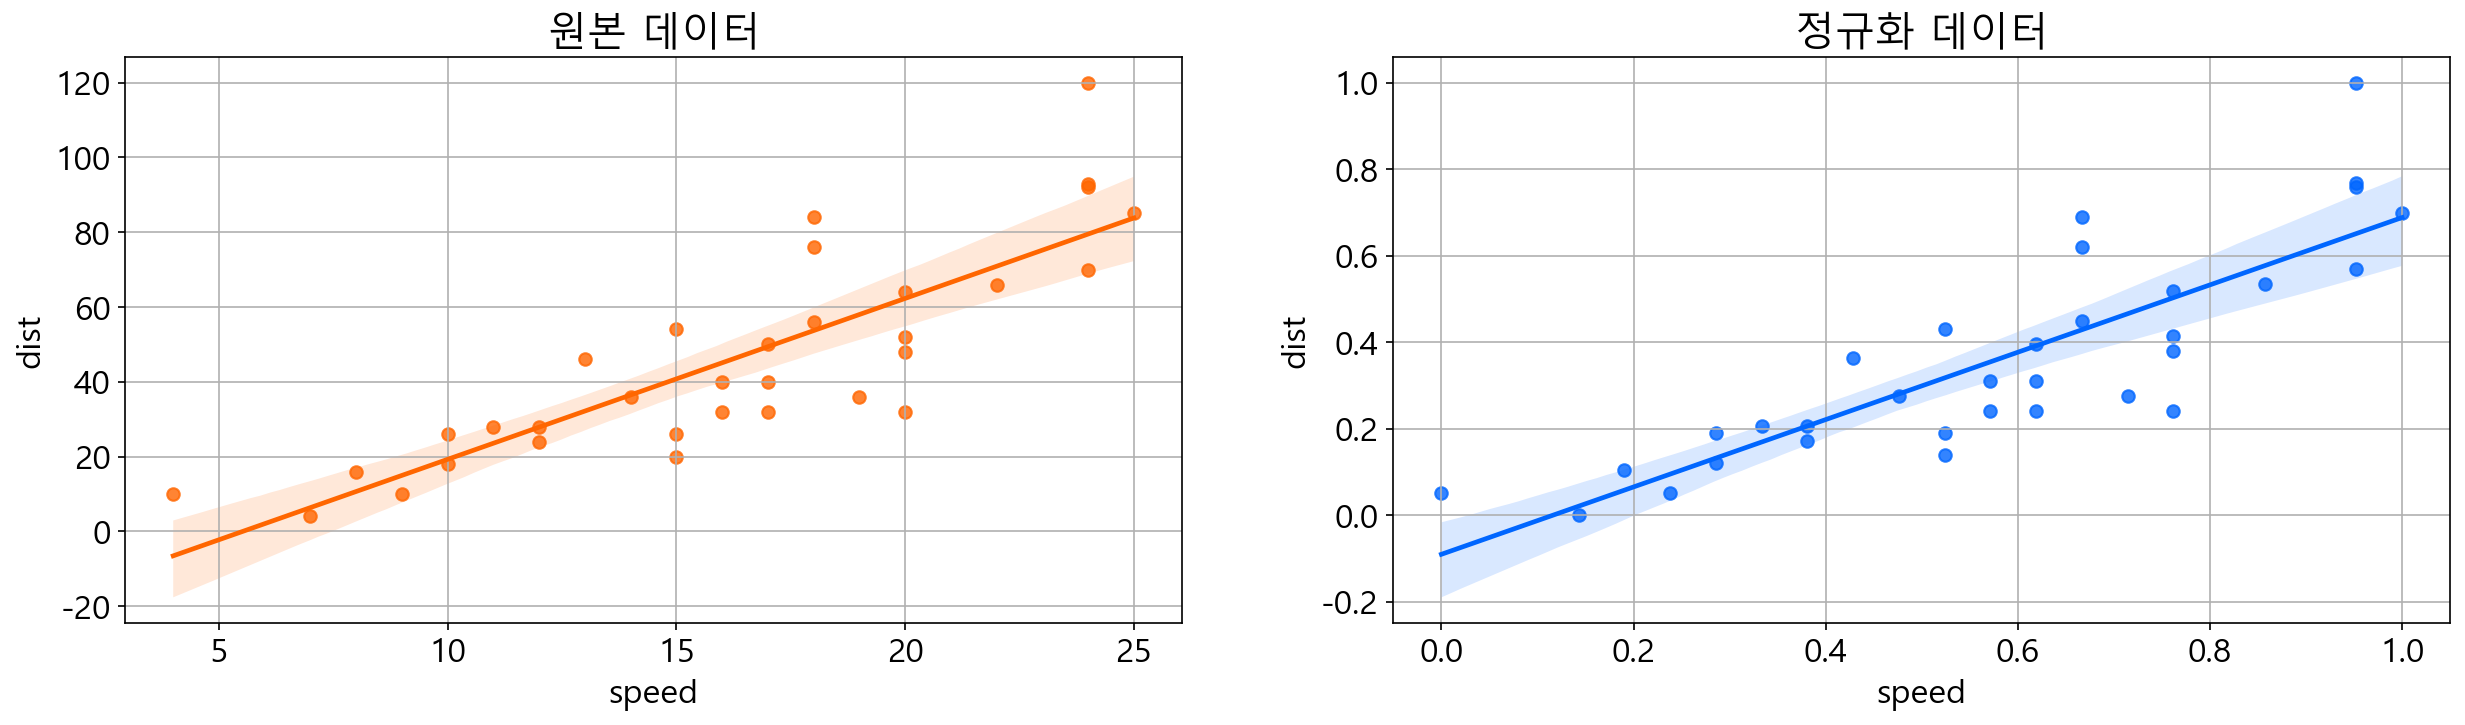

In [8]:
# 데이터 정규화 전, 후 비교

plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

sns.regplot(x=x_train, y=y_train, color='#ff6600', ax=ax1)
ax1.set_title('원본 데이터')
ax1.grid()

sns.regplot(x=std_x_train, y=std_y_train, color='#0066ff', ax=ax2)
ax2.set_title('정규화 데이터')
ax2.grid()

plt.show()
plt.close()

# 데이터의 범위는 0~1 사이로 변화했지만 전체적인 상관관계는 변하지 않았음을 알 수 있다.

### 콜백함수 사용하기

#### 케라스 콜백
모델의 학습방향, 저장시점, 학습정지 시점등에 관한 상황을 모니터링하기위한 도구

In [9]:
# 학습에 대한 콜백함수 처리용 패키지 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
# 학습하기

result = model.fit(std_x_train, std_y_train, epochs=300, validation_data=(std_x_test, std_y_test), callbacks = [
    ModelCheckpoint(filepath = 'reg_check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=10, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

# 학습결과
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/300
2/2 [==============================] - 1s 173ms/step - loss: 0.2264 - mae: 0.4039 - val_loss: 0.1315 - val_mae: 0.3143

Epoch 00001: val_loss improved from inf to 0.13153, saving model to reg_check_point.h5
Epoch 2/300
2/2 [==============================] - 0s 28ms/step - loss: 0.2163 - mae: 0.3922 - val_loss: 0.1249 - val_mae: 0.3048

Epoch 00002: val_loss improved from 0.13153 to 0.12488, saving model to reg_check_point.h5
Epoch 3/300
2/2 [==============================] - 0s 27ms/step - loss: 0.2071 - mae: 0.3817 - val_loss: 0.1189 - val_mae: 0.2960

Epoch 00003: val_loss improved from 0.12488 to 0.11890, saving model to reg_check_point.h5
Epoch 4/300
2/2 [==============================] - 0s 26ms/step - loss: 0.1985 - mae: 0.3720 - val_loss: 0.1131 - val_mae: 0.2873

Epoch 00004: val_loss improved from 0.11890 to 0.11313, saving model to reg_check_point.h5
Epoch 5/300
2/2 [==============================] - 0s 27ms/step - loss: 0.1905 - mae: 0.3624 - val_loss: 0.1074 - v

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.226420,0.403922,0.131532,0.314250,0.001000
2,0.216262,0.392176,0.124884,0.304793,0.001000
3,0.207071,0.381662,0.118899,0.296011,0.001000
4,0.198521,0.371985,0.113132,0.287292,0.001000
5,0.190511,0.362397,0.107413,0.278380,0.001000
...,...,...,...,...,...
58,0.034311,0.146763,0.020235,0.113344,0.000250
59,0.034240,0.146758,0.020246,0.113480,0.000250
60,0.034182,0.146746,0.020249,0.113528,0.000125


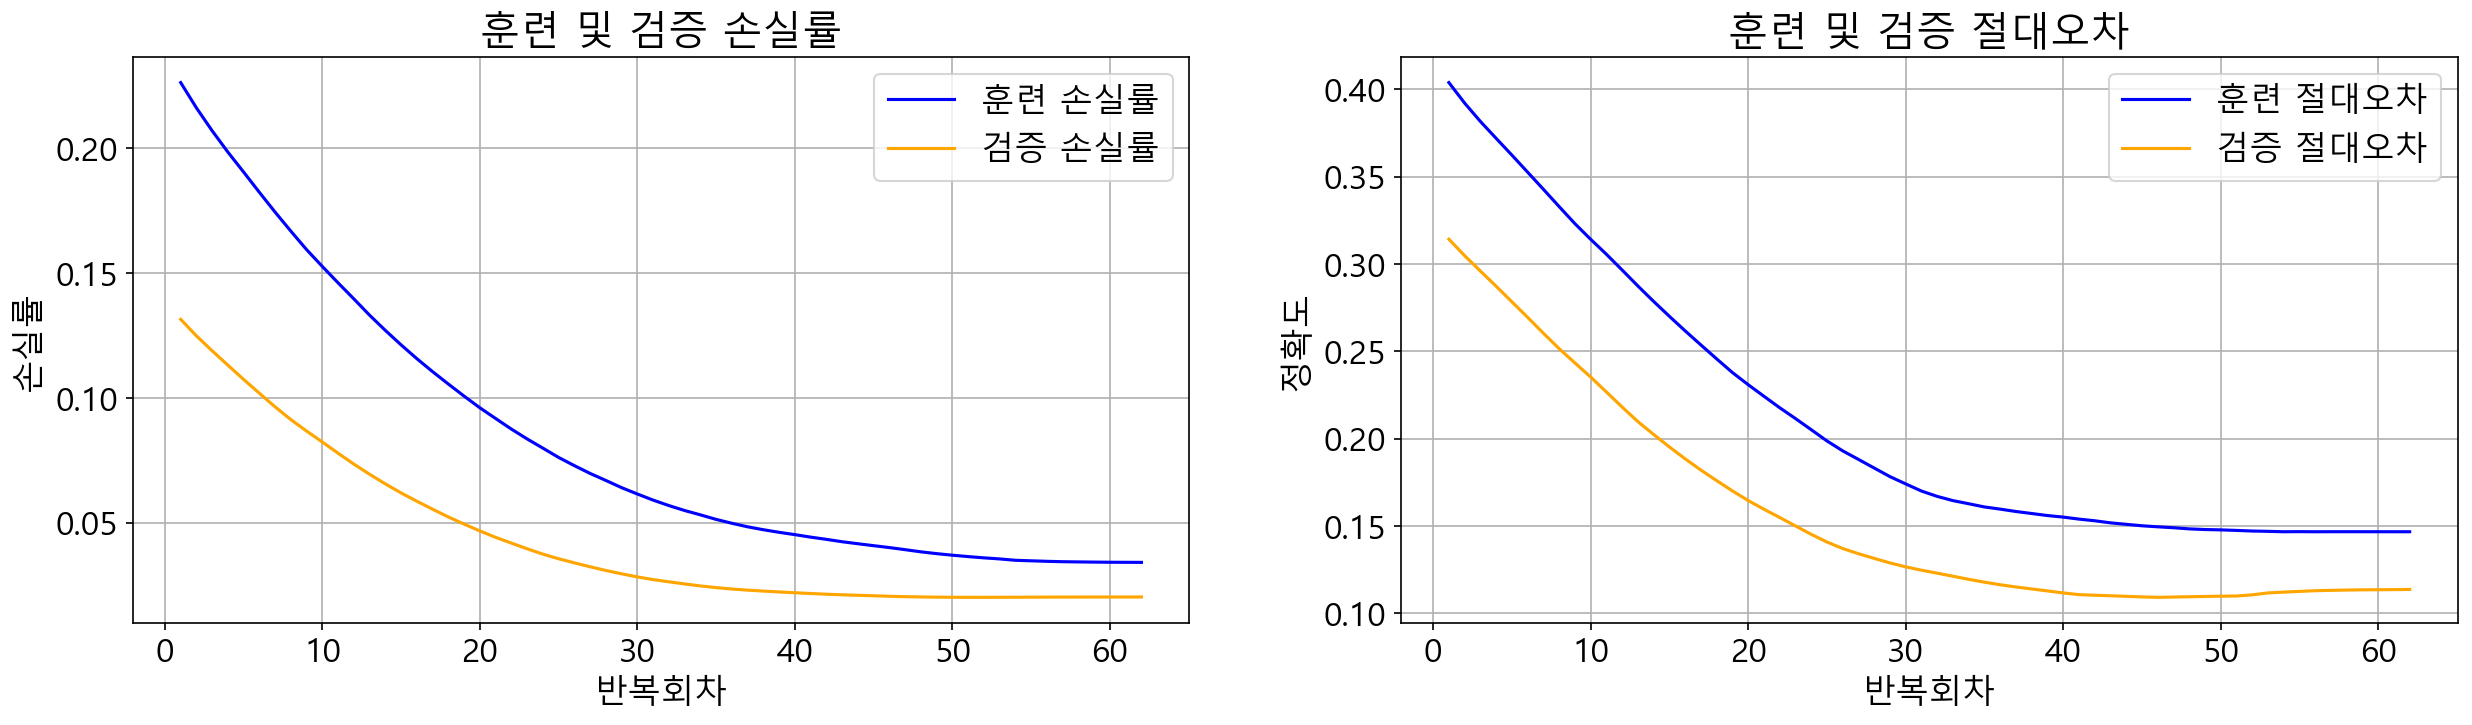

In [11]:
# 학습 결과 시각화

# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', 
             label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', 
             label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', 
             label = '훈련 절대오차', ax=ax2)
sns.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', 
             label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()


# 학습단계에서 반복횟수를 300으로 지정했지만 62번째에 멈춘것을 확인할수있으며
# 즉 학습을 조기종료하으로써 이전보다 성능을 향상시켰다고 볼수있다.